# Black Litterman Model

https://github.com/robertmartin8/PyPortfolioOpt/blob/master/cookbook/4-Black-Litterman-Allocation.ipynb

https://qiita.com/nokomitch/items/0d1812763114e6266bf3

In [1]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import yfinance as yf
import pypfopt as pfo
from pypfopt import plotting

### データ取得

In [2]:
tickers = ["MSFT", "AMZN", "NAT", "BAC", "DPZ", "DIS", "KO", "MCD", "COST"]
start_date = datetime.datetime(2012, 4, 1)
end_date = None #  datetime.datetime(2022, 3, 31)

In [3]:
df_ohlc = yf.download(tickers, period="max")
df_prices = df_ohlc["Adj Close"]
df_prices = df_prices.loc[start_date:end_date]
df_prices.tail()

[*********************100%***********************]  9 of 9 completed


,AMZN,BAC,COST,DIS,DPZ,KO,MCD,MSFT,NAT
Date,,,,,,,,,
2022-06-16,103.660004,31.850000,451.760010,94.279999,379.549988,59.070000,235.190002,244.970001,1.95
2022-06-17,106.220001,31.920000,446.690002,94.339996,379.170013,59.430000,234.380005,247.649994,1.89
2022-06-21,108.680000,32.849998,463.109985,93.290001,386.359985,60.700001,239.589996,253.740005,2.09
2022-06-22,108.949997,32.599998,459.959991,93.500000,389.760010,61.150002,243.059998,253.130005,2.03
2022-06-23,112.440002,32.080002,475.000000,94.300003,398.130005,61.880001,243.580002,258.859985,2.04


In [4]:
df_market_prices = yf.download("SPY", period="max")["Adj Close"]
df_market_prices = df_market_prices.loc[start_date:end_date]
df_market_prices.tail()

[*********************100%***********************]  1 of 1 completed


Date
2022-06-16    365.072998
2022-06-17    365.859985
2022-06-21    375.070007
2022-06-22    374.390015
2022-06-23    378.059998
Name: Adj Close, dtype: float64

In [5]:
mcaps = {t: yf.Ticker(t).info["marketCap"] for t in tickers}
mcaps

{'MSFT': 1936021520384,
 'AMZN': 1144009654272,
 'NAT': 411412896,
 'BAC': 258464727040,
 'DPZ': 14350636032,
 'DIS': 171765563392,
 'KO': 268251643904,
 'MCD': 182013935616,
 'COST': 210630197248}

## Black Litterman Model

### marketから事前情報を取得

In [6]:
S = pfo.risk_models.CovarianceShrinkage(df_prices).ledoit_wolf()

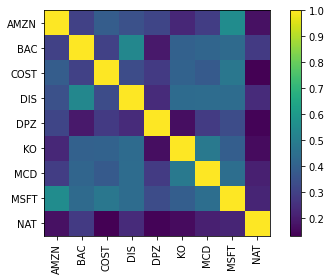

In [7]:
pfo.plotting.plot_covariance(S, plot_correlation=True);

In [8]:
# implied risk aversion
delta = pfo.black_litterman.market_implied_risk_aversion(df_market_prices)
delta

3.883998629483102

In [9]:
# implied prior returns
market_prior = pfo.black_litterman.market_implied_prior_returns(mcaps, delta, S)
market_prior

AMZN    0.231741
BAC     0.159281
COST    0.114356
DIS     0.134117
DPZ     0.109884
KO      0.090210
MCD     0.104942
MSFT    0.219335
NAT     0.139898
dtype: float64

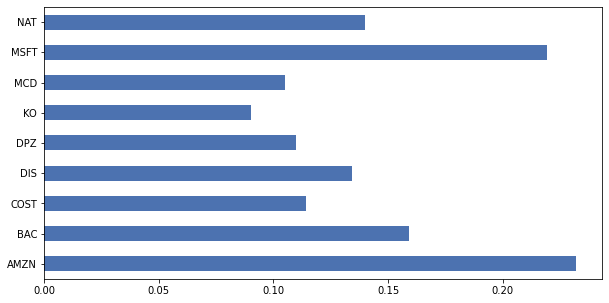

In [10]:
market_prior.plot.barh(figsize=(10,5));

### 投資家の予想

In [11]:
# You don't have to provide views on all the assets
viewdict = {
    "AMZN": 0.10,
    "BAC": 0.30,
    "COST": 0.05,
    "DIS": 0.05,
#     "DPZ": 0.20,
    "KO": -0.05,  # I think Coca-Cola will go down 5%
    "MCD": 0.15,
    "MSFT": 0.10,
    "NAT": 0.20,  # but low confidence, which will be reflected later
}

# view_confidences = [
#     0.6,
#     0.4,
#     0.2,
#     0.5,
#     0.7, # confident in dominos
#     0.7, # confident KO will do poorly
#     0.7, 
#     0.5,
#     0.1,
# ]

### 事後分布を計算
 https://pyportfolioopt.readthedocs.io/en/latest/BlackLitterman.html

In [12]:
bl = pfo.BlackLittermanModel(
    S,
    pi=market_prior,
    absolute_views=viewdict,
#     Q=None,
#     P=None,
#     omega="idzorek",
#     view_confidences=view_confidences,
#     tau=0.05,
#     risk_aversion=1
)

### 結果の確認

In [13]:
# Posterior estimate of returns
return_bl = bl.bl_returns()
return_bl

AMZN    0.151382
BAC     0.185442
COST    0.065511
DIS     0.088402
DPZ     0.083799
KO      0.026227
MCD     0.101295
MSFT    0.149796
NAT     0.161717
dtype: float64

In [14]:
df_returns = pd.DataFrame(
    [market_prior, return_bl, pd.Series(viewdict)],
    index=["Prior", "Posterior", "Views"]
).T
df_returns

,Prior,Posterior,Views
AMZN,0.231741,0.151382,0.10
BAC,0.159281,0.185442,0.30
COST,0.114356,0.065511,0.05
DIS,0.134117,0.088402,0.05
DPZ,0.109884,0.083799,NaN
KO,0.090210,0.026227,-0.05
MCD,0.104942,0.101295,0.15
MSFT,0.219335,0.149796,0.10
NAT,0.139898,0.161717,0.20


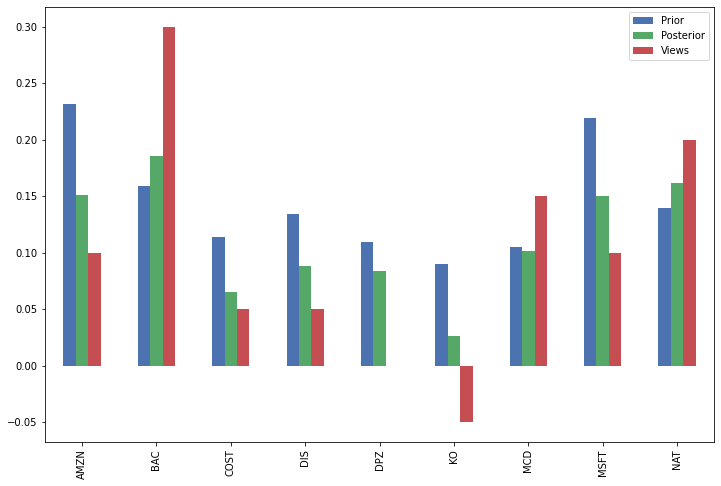

In [15]:
df_returns.plot.bar(figsize=(12,8));

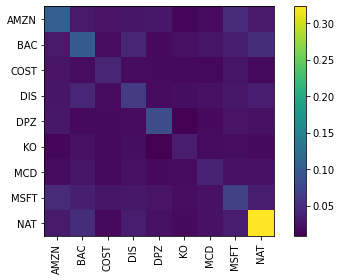

In [16]:
S_bl = bl.bl_cov()
plotting.plot_covariance(S_bl);

### ポートフォリオ最適化

In [17]:
ef = pfo.EfficientFrontier(return_bl, S_bl)
ef.max_sharpe()

OrderedDict([('AMZN', 0.1682577049539032),
             ('BAC', 0.3395247902247508),
             ('COST', 0.0),
             ('DIS', 0.0),
             ('DPZ', 0.0041282791614057),
             ('KO', 0.0),
             ('MCD', 0.211341030392651),
             ('MSFT', 0.2395169261754073),
             ('NAT', 0.037231269091882)])

In [18]:
# market weight
weights = ef.clean_weights()
weights

OrderedDict([('AMZN', 0.16826),
             ('BAC', 0.33952),
             ('COST', 0.0),
             ('DIS', 0.0),
             ('DPZ', 0.00413),
             ('KO', 0.0),
             ('MCD', 0.21134),
             ('MSFT', 0.23952),
             ('NAT', 0.03723)])